# Assignment: Classifying Text

## Crosstraining

Test how well your model, when trained on one dataset, performs on the other.

The idea is to consider the situation where you have labels for one context, but not for the other. So you must train your model your "source context" and hope it generalizes well to your "target context", where you have no labels!

Use the two datasets available in `sentiment/yelp.csv` (online restaurant reviews from Yelp) and `sentiment/movies.csv` (online movie reviews from IMDB). Both have a column called `text` with the text of the review and a column called `positive` which should be your outcome. No other variables are needed.

To do this, make sure that you: 

1. You perform the "fitting" of both the vectorizer and the model on one of the sets
2. Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on. 
3. Use the "predict" of your model to see how well it did on the second dataset. 

How well does your model generalize from one to the other? What does this say about "sentiment"?

## Crosstraining 2

Try to improve your transfer score using the unlabelled target data, P(X). What could you learn from the target context (without using the labels, only from the X) that might help you when training your model on your source context? How can you construct a feature space in your source context that generalizes better? 



> ***Crosstraining 1 & 2 just try to show improvement in score, the ultimate model is in the Ultimate model section ***



# Import Data & Cleaning

## Import Data

In [ ]:
# Run this if running in Google Collab
# Mount google drive if running from Google Collab
from google.colab import drive
drive.mount('/content/drive')

# Set current directory if running from Google Collab

import os
os.chdir('/content/drive/My Drive/Colab Notebooks')# here use your path to current notebook

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)



In [ ]:
import re
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
# EXERCISE 4
#
# Prove Ng and Jordan right!!!

yelps = pd.read_csv('yelps.csv').fillna(' ')
imdb = pd.read_csv('movies.csv').fillna(' ')

## Fixing typos in Positive

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


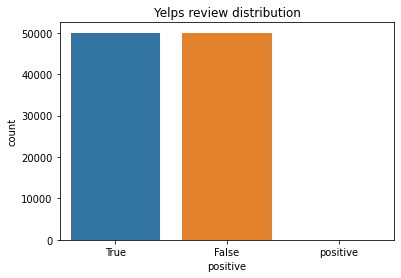

In [ ]:
sns.countplot(yelps.positive);
plt.title('Yelps review distribution');

In [ ]:
yelps.positive[yelps.positive == 'positive'] = 'True'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


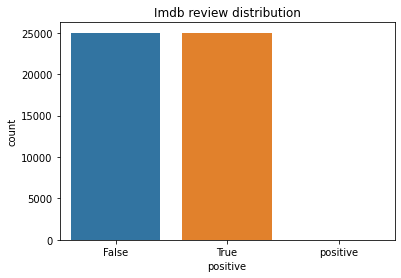

In [ ]:
sns.countplot(imdb.positive);
plt.title('Imdb review distribution');

In [ ]:
imdb.positive[imdb.positive == 'positive'] = 'True'

Hpefully, no imbalance.
Some values in Positive column were 'positive' instead of being 'True'.

# Crosstraining1: Simple Vectorizing and logestic regression

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# License: BSD 3 clause
#from pprint import pprint
#from time import time
#import logging
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re

#lemmitizing with spacy takes to long, so we just do:
def preprocess(X):
  documents = []

  stemmer = WordNetLemmatizer()
  for sen in range(0, len(X)):
    document = re.sub(r'\W', ' ', str(X[sen])) # Remove all the special characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document) # remove all single characters
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)  # Remove single characters from the start
    document = re.sub(r'\s+', ' ', document, flags=re.I) # Substituting multiple spaces with single space
    document = re.sub(r'^b\s+', '', document) # Removing prefixed 'b'
    document = document.lower() # Converting to Lowercase
    document = document.split() # Lemmatization
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    document = re.sub(r'\b\d+(?:\.\d+)?\s+', '', document) #Removes numbers and words containing numbers
    documents.append(document)
  return documents
corpus = preprocess(yelps.text)
corpus_test = preprocess(imdb.text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
vectorizer = TfidfVectorizer(min_df=2,
                            max_df=.8,
                            stop_words='english',
                            use_idf=True,
                            norm='l2')

v = vectorizer.fit_transform(corpus)

We see that words like food, resturant, order are yelps corpus specific and won't be handy in the imdb corpus transformation.

In [ ]:
y = yelps.positive 
model = LogisticRegression().fit(v, y)
score = model.score(v, y)
print(f'score for train data: {score}')

score for train data: 0.9673209803705889


In [ ]:
v_test = vectorizer.transform(corpus_test)
y_test = imdb.positive 
score = model.score(v_test, y_test)
print(f'score for test data: {score}')

score for test data: 0.7971921684698918


***Conclusion: Obviously, jumping into making a vectorizer and running a logestic regression will end up better fit (Probably overfit) on the train data and underpreform on the test data. We need to do the following as a better approach: ***

1.   We need to find common words to train our model since we have datasets that are in different areas. (Done by passing the vectorizer.vocabulary_)
2.   We need to try different vectorizers and classifiers. (Making pipelines)
3.   We need some hyperparameter tuining. (Using gridsearchcv on the pipelines)

#Crosstraining2: Using best model and transform by test data

In [ ]:
vocab1 = vectorizer.vocabulary_
vectorizer_test = TfidfVectorizer(min_df=2,
                            max_df=0.8,
                            stop_words='english',
                            use_idf=True,
                            norm='l2',
                            vocabulary = vocab1)
v_test = vectorizer_test.fit_transform(corpus_test)
vocab2 = vectorizer_test.vocabulary_


In [ ]:
score = model.score(v_test, y_test)
print(f'score for test data: {score}')

score for test data: 0.7641941483510989


Since we transformed test data using vocabulary fron train data, the score did not improve. The best way to improve this is to tokenize(vectorize) using both datasets and then train the model on train data.

In [ ]:
ult_vectorizer = TfidfVectorizer(min_df=2,
                            max_df=0.8,
                            stop_words='english',
                            use_idf=True,
                            norm='l2',)
ult_corpus = corpus+corpus_test
ult_vectorizer.fit(ult_corpus)    #Unsupervise vectorizer for both data sets
v_test_ult = ult_vectorizer.transform(corpus_test)
v_train_ult = ult_vectorizer.transform(corpus)
model_ult = LogisticRegression().fit(v_train_ult, y) # supervised model just on the training data
score = model_ult.score(v_train_ult, y)
print(f'score for train data: {score}')
score = model_ult.score(v_test_ult, y_test) #improved score
print(f'score for test data: {score}')

score for train data: 0.9669809905702829
score for test data: 0.7957522548647081


We see that under Ceteris paribus score for test data improves only when we combine two data sets for vectorizing.

# Ultimate Model

We can test different feature extraction methods and different classifiers to improve fitting and we can tune hyperparameters. Since running pipelines with different classifiers takes a lot of time, we just tune hyperparameters for Tfidfvectorizer and LogesticRegression here. 

In [ ]:
# Pipeline & Gridsearch setup
# TFIDF pipeline setup
tvc_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('lr', LogisticRegression())
])

# Setting params for TFIDF Vectorizer gridsearch
tf_params = {
 'tvec__min_df':[10],
 'tvec__max_df': [0.8],
 'tvec__norm': ['l2'],
 'tvec__use_idf': [True],
 'lr__penalty': ['l2'],
 'lr__solver': ['liblinear']
}

# Setting up GridSearch for TFIDFVectorizer
tvc_gs = GridSearchCV(tvc_pipe, param_grid=tf_params, cv = 5, verbose =1, n_jobs = 100)
tvc_gs.fit(corpus, y)
# Scoring Training data on TFIDFVectorizer
print(f'score for train data: {tvc_gs.score(corpus, y)}')
# Scoring Test data on TFIDFVectorizer
print(f'score for test data: {tvc_gs.score(corpus_test, y_test)}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of 100 | elapsed:   52.0s remaining: 42.5min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed: 21.8min finished


score for train data: 0.9713108606741798
score for test data: 0.800811951282923


In [ ]:
tvc_gs.best_estimator_

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=10, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

Since the fits increase exponentially (2^n), I have used Gridsearchcv with 5 folds multiple times and each time chosed the best params, however, I know that this does not cover all the possible fits and thus may not contain the optimal fit:

***1st:*** test score=0.8007

 'tvec__min_df':[0.05, 0.01, 2, 10],

 'tvec__max_df': [0.9, 0.8],

***2nd:*** test score=0.8007

 'tvec__min_df':[10,20,50],

 'tvec__max_df': [0.8,0.85,0.75],

 ***3ed:*** test score=0.8007

  'tvec__norm': ['l1', 'l2'],

 'tvec__use_idf': [True, False],

 ***4th:*** test score=0.8008

  'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],


 'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']


It seems that the score can change only if we change the classifier, preprocessing, and tokenizer.